In [25]:
import torch
import torchvision

from torchvision import models
import transformers
from transformers import PvtModel, AutoImageProcessor

from fir.datasets import deep_fashion_ctsrbm

import os
import pathlib

import numpy as np

from datasets import load_dataset

from tqdm.notebook import tqdm

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
from PIL import Image
import requests

url = "http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg"
im = Image.open(requests.get(url, stream=True).raw)
im_2 = torchvision.transforms.ToTensor()(im)

In [36]:
im_2.shape

torch.Size([3, 2400, 1800])

In [30]:
im.shape

AttributeError: 'JpegImageFile' object has no attribute 'shape'

In [27]:
dataset = load_dataset("beans", split="train").cast_column("image", Image(decode=False))
dataset[0]["image"]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

{'bytes': None,
 'path': '/home-net/gortega/.cache/huggingface/datasets/downloads/extracted/f610d1711e0269a8fee838327126d9991911d70b053bbc88f981f3a823a07ff5/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg'}

In [ ]:
def show_img(idx):

    image, item_id = ctsrbm_dataset[idx]

    image_copy = image

    if type(image) == torch.Tensor:
        image_copy = image_copy.permute(1, 2, 0)

    vmax = image_copy.max().item()
    vmin = image_copy.min().item()

    image_copy = (image_copy - vmin) / (vmax - vmin)

    plt.imshow(image_copy)
    
    title_lines = []
    title_lines.append("Image ID: {:d}".format(idx))
    title_lines.append("Item ID: {:d}".format(item_id))
    title_lines.append("Size: " + str(image_copy.size()))
    plt.title("\n".join(title_lines))

    plt.show()

---

In [13]:
path_to_img = os.path.join(
    pathlib.Path.home(),
    "data",
    "DeepFashion",
    "Consumer-to-shop Clothes Retrieval Benchmark",
    "img",
    "CLOTHING",
    "Blouse",
    "id_00004848",
    "comsumer_01.jpg"
)

img_original = torchvision.io.read_image(path_to_img)

In [14]:
print(img_original.shape)

torch.Size([3, 300, 169])


In [15]:
ctsrbm_image_transform = AutoImageProcessor.from_pretrained("Zetatech/pvt-small-224")
#ctsrbm_image_transform.size["height"] = 224
#ctsrbm_image_transform.size["width"] = 224
ctsrbm_image_transform_corr = lambda t: torch.from_numpy(ctsrbm_image_transform(t).pixel_values[0])

In [16]:
ctsrbm_image_transform

PvtImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "PvtImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [17]:
img_transformed = ctsrbm_image_transform_corr(img_original)

In [19]:
img_transformed.shape

torch.Size([3, 224, 224])

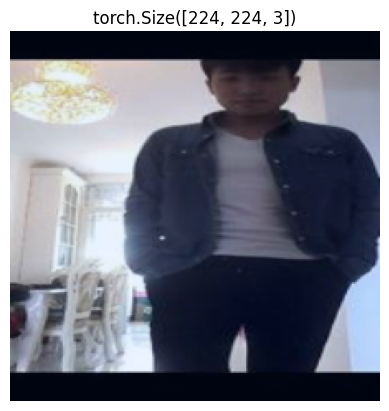

In [24]:
img_copy = torch.clone(img_transformed)
img_copy = img_copy.permute(1, 2, 0)

vmax = img_copy.max().item()
vmin = img_copy.min().item()

img_copy = (img_copy - vmin) / (vmax - vmin)

plt.imshow(img_copy)
plt.title(str(img_copy.shape))
plt.axis("off")
plt.show()

---

In [2]:
model = PvtModel.from_pretrained("Zetatech/pvt-small-224")

In [3]:
ctsrbm_image_transform = AutoImageProcessor.from_pretrained("Zetatech/pvt-small-224")
ctsrbm_image_transform.size["height"] = 448
ctsrbm_image_transform.size["width"] = 448
ctsrbm_image_transform_corr = lambda t: torch.from_numpy(ctsrbm_image_transform(t).pixel_values[0])
ctsrbm_dataset_dir = os.path.join(pathlib.Path.home(), "data", "DeepFashion", "Consumer-to-shop Clothes Retrieval Benchmark")
ctsrbm_dataset = deep_fashion_ctsrbm.ConsToShopClothRetrBmkImageLoader(ctsrbm_dataset_dir, ctsrbm_image_transform_corr)

In [4]:
ctsrbm_image_transform

PvtImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "PvtImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 448,
    "width": 448
  }
}

In [5]:
input = ctsrbm_dataset[0]

img_tensor = input[0]
item_id = input[1]

In [6]:
print(img_tensor.shape)

torch.Size([3, 448, 448])


In [7]:
item_id

24444

In [8]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

model.encoder.block[0].register_forward_hook(get_activation('encoder.block[0]'))
model.encoder.block[1].register_forward_hook(get_activation('encoder.block[1]'))
model.encoder.block[2].register_forward_hook(get_activation('encoder.block[2]'))
model.encoder.block[3].register_forward_hook(get_activation('encoder.block[3]'))
model.encoder.layer_norm.register_forward_hook(get_activation('encoder.layer_norm'))
model.encoder.register_forward_hook(get_activation('encoder'))

In [9]:
input = ctsrbm_dataset[0][0][None, :, :224, :224]
output = model(input)

HOLA

batch_size: 1
num_channels: 3
height: 224
width: 224

height: 56
width: 56

embeddings.shape: torch.Size([1, 3136, 64])

self.cls_token is None

  CALL: interpolate_pos_encoding
  embeddings.shape: torch.Size([1, 3136, 64])
  height: 56
  width: 56

  num_patches: 3136
  self.config.image_size: 224
  self.config.image_size ** 2: 50176

  embeddings.shape: torch.Size([1, 3136, 64])
  embeddings.shape: torch.Size([1, 64, 56, 56])
  interpolated_embeddings.shape: torch.Size([1, 64, 56, 56])
  interpolated_embeddings.shape: torch.Size([1, 3136, 64])

self.position_embeddings.shape: torch.Size([1, 3136, 64])
position_embeddings.shape: torch.Size([1, 3136, 64])


---

HOLA

batch_size: 1
num_channels: 64
height: 56
width: 56

height: 28
width: 28

embeddings.shape: torch.Size([1, 784, 128])

self.cls_token is None

  CALL: interpolate_pos_encoding
  embeddings.shape: torch.Size([1, 784, 128])
  height: 28
  width: 28

  num_patches: 784
  self.config.image_size: 224
  self.config.image

In [10]:
input = ctsrbm_dataset[0][0][None, :, :448, :448]
output = model(input)

HOLA

batch_size: 1
num_channels: 3
height: 448
width: 448

height: 112
width: 112

embeddings.shape: torch.Size([1, 12544, 64])

self.cls_token is None

  CALL: interpolate_pos_encoding
  embeddings.shape: torch.Size([1, 3136, 64])
  height: 112
  width: 112

  num_patches: 12544
  self.config.image_size: 224
  self.config.image_size ** 2: 50176

  embeddings.shape: torch.Size([1, 3136, 64])
  embeddings.shape: torch.Size([1, 16, 112, 112])
  interpolated_embeddings.shape: torch.Size([1, 16, 112, 112])
  interpolated_embeddings.shape: torch.Size([1, 12544, 16])

self.position_embeddings.shape: torch.Size([1, 3136, 64])
position_embeddings.shape: torch.Size([1, 12544, 16])



RuntimeError: The size of tensor a (64) must match the size of tensor b (16) at non-singleton dimension 2